In [36]:
%%time
import torch
import numpy as np
from collections import defaultdict, Counter
from transformers import EsmTokenizer, EsmForMaskedLM

max_len = 280
mask_prob = 0.15

# Load tokenizer and model
model_name = "facebook/esm2_t6_8M_UR50D"  # Adjust for a larger model if needed
tokenizer = EsmTokenizer.from_pretrained(model_name, cache_dir=".cache")
model = EsmForMaskedLM.from_pretrained(model_name, cache_dir=".cache")

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Example protein sequence 
sequences = [
    "RVQPTESIVRFPNITNLCPFGEVFNATRFSSVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNF",
    "RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNPAPFFTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNKLDSKVSGNYNYLYRLFRKSNLKPFERDISTEIYQAGNKPCNGVAGFNCYFPLRSYSFRPTYGVGHQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNF",
    "RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNF",
    "RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNF",
    "RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNLAPFFTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNKLDSKVSGNYNYLYRLFRKSNLKPFERDISTEIYQAGNKPCNGVAGFNCYFPLRSYSFRPTYGVGHQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNF",
]             

# Tokenize original sequence
tokenized_seqs = tokenizer(sequences, return_tensors="pt", padding=True, truncation=True, max_length=max_len)
tokenized_seqs = {k: v.to(device) for k, v in tokenized_seqs.items()}
original_ids = tokenized_seqs["input_ids"]

# Mask 15% randomly
rand = torch.rand(original_ids.shape).to(device)
mask_arr = (rand < mask_prob) * \
           (original_ids != tokenizer.cls_token_id) * \
           (original_ids != tokenizer.eos_token_id) * \
           (original_ids != tokenizer.pad_token_id)

masked_original_ids = original_ids.clone()
masked_original_ids[mask_arr] = tokenizer.mask_token_id

# Get results
with torch.no_grad():
    outputs = model(masked_original_ids, labels=original_ids)
    preds = outputs.logits # Shape: (batch_size, sequence_length, vocab_size)
    loss = outputs.loss
    print(preds.shape, loss)

# Get predicted token IDs for each sequence
predicted_ids = torch.argmax(preds, dim=-1)  # Shape: (batch_size, sequence_length)

# Compute mask where original was masked
mask = (masked_original_ids == tokenizer.mask_token_id)

# Get original and predicted tokens at masked positions
original_tokens = original_ids[mask]
predicted_tokens = predicted_ids[mask]

# Calculate accuracy per sequence
correct_preds = (original_tokens == predicted_tokens).sum().item()
total_masked = mask.sum().item()
accuracy = (correct_preds / total_masked) * 100 if total_masked > 0 else 0.0

# Track amino acid predictions
aa_keys = [f"{tokenizer.convert_ids_to_tokens(o)}->{tokenizer.convert_ids_to_tokens(p)}"
           for o, p in zip(original_tokens.tolist(), predicted_tokens.tolist())]
counter = Counter(aa_substitutions)

torch.Size([5, 225, 33]) tensor(0.8194, device='cuda:0')
CPU times: user 9.28 s, sys: 511 ms, total: 9.79 s
Wall time: 324 ms


In [37]:
%%timeit
aa_pred_counter = defaultdict(int)
for aa_key in aa_keys:
    aa_pred_counter[aa_key] += 1

13.8 µs ± 39.1 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [38]:
%%timeit
aa_pred_counter = Counter(aa_keys)

6.01 µs ± 32.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Write as a train loop:

In [39]:
%%time
import torch
import numpy as np
from collections import defaultdict, Counter
from transformers import EsmTokenizer, EsmForMaskedLM, AdamW

# Training configuration
num_epochs = 5
lr = 5e-5
max_len = 280
mask_prob = 0.15

# Initialize model and tokenizer
model_name = "facebook/esm2_t6_8M_UR50D"
tokenizer = EsmTokenizer.from_pretrained(model_name, cache_dir=".cache")
model = EsmForMaskedLM.from_pretrained(model_name, cache_dir=".cache")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Sample protein sequences (same as before)
sequences = [
    "RVQPTESIVRFPNITNLCPFGEVFNATRFSSVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNF",
    "RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNPAPFFTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNKLDSKVSGNYNYLYRLFRKSNLKPFERDISTEIYQAGNKPCNGVAGFNCYFPLRSYSFRPTYGVGHQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNF",
    "RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNF",
    "RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYRYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNF",
    "RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVADYSVLYNLAPFFTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGNIADYNYKLPDDFTGCVIAWNSNKLDSKVSGNYNYLYRLFRKSNLKPFERDISTEIYQAGNKPCNGVAGFNCYFPLRSYSFRPTYGVGHQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNF",
]   

# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=0.01)
aa_preds_tracker = {}

# Training loop
for epoch in range(num_epochs):
    model.train()
    aa_substitutions = []
    
    # Tokenize sequences fresh each epoch (simulating different batches)
    tokenized_seqs = tokenizer(sequences, return_tensors="pt", padding=True, 
                              truncation=True, max_length=max_len)
    tokenized_seqs = {k: v.to(device) for k, v in tokenized_seqs.items()}
    original_ids = tokenized_seqs["input_ids"]
    
    # Generate new mask for each epoch
    rand = torch.rand(original_ids.shape, device=device)
    mask_arr = (rand < mask_prob) * \
               (original_ids != tokenizer.cls_token_id) * \
               (original_ids != tokenizer.eos_token_id) * \
               (original_ids != tokenizer.pad_token_id)
    
    masked_original_ids = original_ids.clone()
    masked_original_ids[mask_arr] = tokenizer.mask_token_id

    # Forward pass
    optimizer.zero_grad()
    outputs = model(masked_original_ids, labels=original_ids)
    loss = outputs.loss
    preds = outputs.logits
    
    # Backward pass and optimize
    loss.backward()
    optimizer.step()
    
    # Calculate metrics
    predicted_ids = torch.argmax(preds, dim=-1)
    mask = (masked_original_ids == tokenizer.mask_token_id)
    
    original_tokens = original_ids[mask]
    predicted_tokens = predicted_ids[mask]
    correct = (original_tokens == predicted_tokens).sum().item()
    total = mask.sum().item()
    accuracy = (correct / total) * 100 if total > 0 else 0.0

    aa_keys = [f"{tokenizer.convert_ids_to_tokens(o.item())}->{tokenizer.convert_ids_to_tokens(p.item())}"
               for o, p in zip(original_tokens, predicted_tokens)]
    aa_substitutions.extend(aa_keys)
    
    # Print epoch summary
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"Loss: {loss.item():.4f} | Accuracy: {accuracy:.2f}%")
    print("Top substitutions:")
    counter = Counter(aa_substitutions)
    aa_preds_tracker[epoch + 1] = counter
    for sub, count in counter.most_common(5):
        print(f"{sub}: {count}x")


Epoch 1/5
Loss: 0.8407 | Accuracy: 3.53%
Top substitutions:
I->L: 7x
N->S: 6x
P->S: 6x
Y->S: 6x
S->G: 5x

Epoch 2/5
Loss: 0.8260 | Accuracy: 5.17%
Top substitutions:
N->S: 9x
Y->S: 7x
S->S: 6x
E->S: 6x
K->S: 6x

Epoch 3/5
Loss: 0.8069 | Accuracy: 4.71%
Top substitutions:
C->S: 7x
N->S: 7x
Y->G: 6x
F->S: 6x
F->L: 5x

Epoch 4/5
Loss: 0.8005 | Accuracy: 7.43%
Top substitutions:
V->S: 8x
L->S: 7x
G->S: 7x
T->S: 6x
N->S: 5x

Epoch 5/5
Loss: 0.7746 | Accuracy: 5.92%
Top substitutions:
N->S: 8x
F->S: 7x
Y->S: 6x
V->L: 5x
T->S: 5x
CPU times: user 23.6 s, sys: 1.13 s, total: 24.7 s
Wall time: 494 ms


Make sure this saved properly for access later:

In [40]:
for epoch, counter in aa_preds_tracker.items():
    print(f"\nEpoch {epoch} Top Substitutions:")
    for sub, count in counter.most_common(5):
        print(f"{sub}: {count}x")


Epoch 1 Top Substitutions:
I->L: 7x
N->S: 6x
P->S: 6x
Y->S: 6x
S->G: 5x

Epoch 2 Top Substitutions:
N->S: 9x
Y->S: 7x
S->S: 6x
E->S: 6x
K->S: 6x

Epoch 3 Top Substitutions:
C->S: 7x
N->S: 7x
Y->G: 6x
F->S: 6x
F->L: 5x

Epoch 4 Top Substitutions:
V->S: 8x
L->S: 7x
G->S: 7x
T->S: 6x
N->S: 5x

Epoch 5 Top Substitutions:
N->S: 8x
F->S: 7x
Y->S: 6x
V->L: 5x
T->S: 5x


In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame.from_dict(aa_preds_tracker, orient='index').T

# Rename columns for clarity
df.columns = [f'epoch {i}' for i in df.columns]

# Reset index and rename the index column
df.rename_axis(index='expected_aa->predicted_aa', inplace=True)
df.reset_index(inplace=True)

# Fill NaN values with 0 and sort by total count
df = df.fillna(0)
df['total'] = df.iloc[:, 1:].sum(axis=1)
df = df.sort_values('total', ascending=False).drop('total', axis=1)

# Reset index again
df = df.reset_index(drop=True)
df

,expected_aa->predicted_aa,epoch 1,epoch 2,epoch 3,epoch 4,epoch 5
0,N->S,6.0,9.0,7.0,5.0,8.0
1,Y->S,6.0,7.0,4.0,4.0,6.0
2,T->S,3.0,3.0,5.0,6.0,5.0
3,V->L,4.0,3.0,4.0,5.0,5.0
4,F->S,2.0,3.0,6.0,3.0,7.0
...,...,...,...,...,...,...
137,E->P,0.0,1.0,0.0,0.0,0.0
138,P->T,0.0,1.0,0.0,0.0,0.0
139,D->D,0.0,0.0,1.0,0.0,0.0
140,Q->G,0.0,0.0,1.0,0.0,0.0


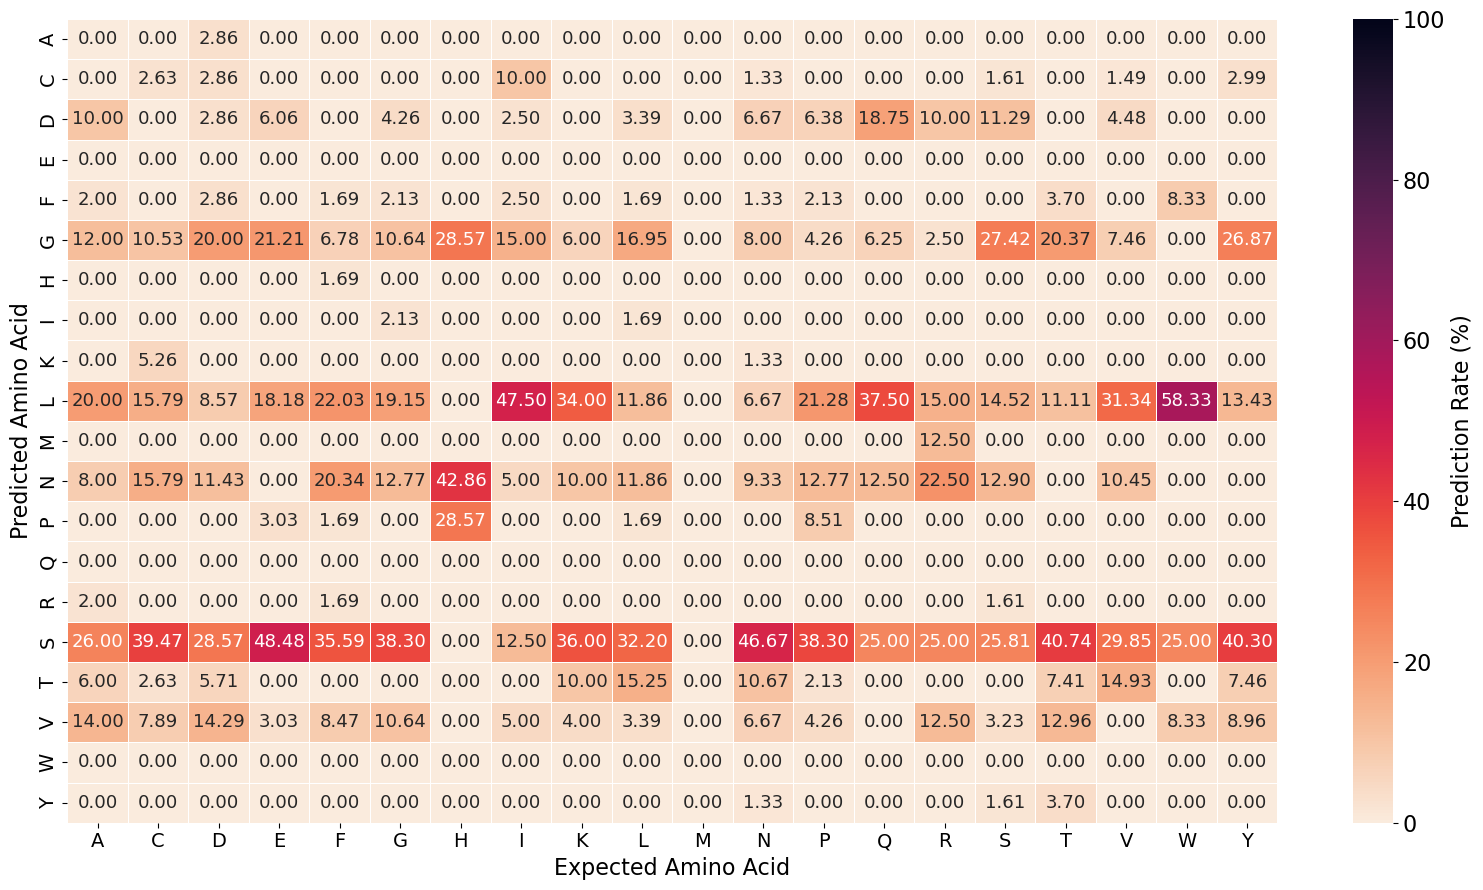

In [42]:
def plot_aa_preds_heatmap(df):
    """ Plots heatmap of expected vs predicted amino acid incorrect prediction counts. Expected on x axis. """
    # Create a DataFrame with all possible amino acid combinations
    ALL_AAS = 'ACDEFGHIKLMNPQRSTVWY'
    all_combinations = [(e_aa, p_aa) for e_aa in ALL_AAS for p_aa in ALL_AAS]
    all_df = pd.DataFrame(all_combinations, columns=["Expected", "Predicted"])

    # Split 'expected_aa->predicted_aa' into separate columns
    df[['Expected', 'Predicted']] = df['expected_aa->predicted_aa'].str.split('->', expand=True)

    # Ensure that the epoch columns are numeric and fill any NaNs with 0
    epoch_columns = df.columns[1:-2]  # Assuming epoch columns start at index 1 and go up to the second last column
    df[epoch_columns] = df[epoch_columns].apply(pd.to_numeric, errors='coerce').fillna(0)

    # Sum the counts across all epochs to get the total error count for each expected->predicted pair
    total_count = df[epoch_columns].sum(axis=1)
    df = pd.concat([df, total_count.rename('Total Count')], axis=1)

    # Merge with all possible amino acid combinations so missing pairs get a count of 0
    df = pd.merge(all_df, df[['Expected', 'Predicted', 'Total Count']], how="left", on=["Expected", "Predicted"])
    df["Total Count"].fillna(0, inplace=True)

    # Calculate the total counts for each expected amino acid
    total_counts = df.groupby("Expected")["Total Count"].sum()
    df["Expected Total"] = df["Expected"].map(total_counts)

    # Calculate error percentage
    df["Error Percentage"] = (df["Total Count"] / df["Expected Total"]) * 100
    df["Error Percentage"].fillna(0, inplace=True)

    # Pivot the DataFrame to create a heatmap data structure
    heatmap_data = df.pivot_table(index="Predicted", columns="Expected", values="Error Percentage")

    # Set figure size
    plt.figure(figsize=(16, 9))
    fontsize=16

    # Plot
    cmap = sns.color_palette("rocket_r", as_cmap=True)
    heatmap = sns.heatmap(
        heatmap_data,
        annot=True, fmt=".2f",
        linewidth=.5,
        cmap=cmap, vmin=0, vmax=100,
        annot_kws={"size": 13},
        cbar_kws={'drawedges': False, 'label': 'Prediction Rate (%)'}
    )

    colorbar = heatmap.collections[0].colorbar
    colorbar.ax.tick_params(labelsize=fontsize)  # Set colorbar tick label size
    colorbar.set_label('Prediction Rate (%)', size=fontsize)  # Set colorbar label size

    plt.xlabel('Expected Amino Acid', fontsize=fontsize)
    plt.xticks(rotation=0, fontsize=fontsize-2)
    plt.ylabel('Predicted Amino Acid', fontsize=fontsize)
    plt.yticks(fontsize=fontsize-2)

    plt.tight_layout()
    plt.show()

plot_aa_preds_heatmap(df)